In [3]:
"""
Zuerst stellen wir sicher, dass wir alle notwendigen Bibliotheken importieren:
"""
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
import helper
from tqdm import tqdm
import numpy as np


# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
# Simple Neural Network
# Had to comment out the following lines to run the code locally
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define the size of the individual images
# and the batch size
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
       # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [10]:
# load dataset: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset
data_dir = 'Data/Train'

dataset = datasets.ImageFolder(data_dir, transform=transform)
# only load a subet because it's faster
dataset_subset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 100, replace=False))

In [11]:
len(dataset_subset)

100

In [ ]:
# split the data
train_dataset, test_dataset = torch.utils.data.random_split(dataset_subset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

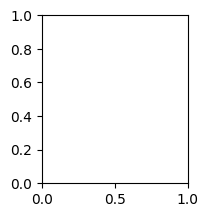

In [12]:
# look at one batch of images
examples = iter(dataset_subset) # create iterable object
samples, labels = next(examples)  # unpack the batch
# make a plot
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow((samples[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()

In [ ]:
"""
Nun definieren wir unser eigenständiges CNN-Modell mit 3 Layern:
"""
# Definition des eigenen CNN-Modells
class CustomCNNModel(nn.Module):
    def __init__(self, num_classes=100):
        super(CustomCNNModel, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = torch.nn.Linear(3 * 56 * 56, num_classes, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Device configuration, Prüfe ob GPU verfügbar ist, falls ja, lasse das Modell auf eie GPU laufen, ansonsten CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CustomCNNModel(num_classes=2)
model.to(device)

CustomCNNModel(
  (layer1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=9408, out_features=2, bias=True)
)

In [ ]:
model

CustomCNNModel(
  (layer1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=9408, out_features=2, bias=True)
)

In [ ]:
"""
Als nächstes definieren wir die Loss Function und den Optimizer:
"""
# Verlustfunktion und Optimierer definieren
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
"""
Trainieren des Modells
"""
# Trainingsschleife
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_samples = 0
    pbar = tqdm(train_loader)
    nr_samples = 0
    for idx, (images, labels) in enumerate(pbar, start=1):
        # Vorhersage und Verlust berechnen
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Gradienten zurücksetzen, Backwardpropagation und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        nr_samples += images.shape[0]
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels)
        cnt_acc = running_corrects/nr_samples
        cnt_loss = running_loss/nr_samples
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cnt_loss:.3f}, Acc: {cnt_acc:.3f}')

Epoch [10/10], Loss: 0.013, Acc: 0.805: 100%|██████████| 250/250 [00:44<00:00,  5.61it/s]


In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
errors = []
model.eval()
running_corrects = 0
nr_samples = 0
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds == labels)
    nr_samples += images.shape[0]
    #if preds != labels:
    #  errors.append({"image":images.to("cpu")[0], "y_hat":preds.to("cpu")[0].item(), "label":labels.to("cpu")[0].item()})
print()
print(f"Accuracy on Test dataset: {(running_corrects/nr_samples)*100:.3f} %")

100%|██████████| 32/32 [05:05<00:00,  9.55s/it]


Accuracy on Test dataset: 62.500 %


In [ ]:
# Show some errors
idx = 1
print(f"Label: {errors[idx]['label']}, Prediction: {errors[idx]['y_hat']}")
plt.imshow((errors[idx]['image'].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()

IndexError: list index out of range